In [33]:
from models.api_models import *
from tqdm import tqdm
import time
import joblib
from models.feature_extractor import FeatureExtractor
from models.win_rate_models import WinRateSciKitModel
from models.mcts_draft import AllPickDraft, CaptainsModeDraft, getOrderedMoves
from mcts import mcts
from copy import deepcopy
import seaborn as sns

In [2]:
EVALUATE_PICKE_PATH = 'input/pro_pb.joblib' 

In [3]:
feature_extractor = joblib.load('input/feature_extractor.joblib')
linear_svc = joblib.load('input/linear_svc.joblib')
win_rate_model = WinRateSciKitModel(feature_extractor, linear_svc)

In [4]:
picks_bans_list = joblib.load(EVALUATE_PICKE_PATH)

In [19]:
def to_initial_state(pb_list, wr_model):
    bans = []
    radiant_picks = []
    dire_picks = []
    for pb in pb_list:
        if not pb.is_pick:
            bans.append(pb.hero_id)
        else:
            if pb.team == 1:
                radiant_picks.append(pb.hero_id)
            else:
                dire_picks.append(pb.hero_id)
    state = AllPickDraft(wr_model, bans=bans, radiant_picks=set(radiant_picks[:3]), dire_picks=set(dire_picks[:3]))
    return state, radiant_picks[3:], dire_picks[3:]

In [20]:
pick_bans_states = [to_initial_state(picks_bans, win_rate_model) for picks_bans in picks_bans_list]

In [21]:
pick_bans_states

[({'b': {98, 39, 106, 77, 110, 46, 80, 16, 114, 86, 120, 58}, 'r': {75, 83, 91}, 'd': {33, 7, 63}, 'i': True, 'c': 1},
  [19, 48],
  [38, 67]),
 ({'b': {33, 66, 3, 98, 36, 38, 39, 106, 77, 110, 22, 58}, 'r': {80, 86, 30}, 'd': {16, 91, 63}, 'i': True, 'c': 1},
  [4, 129],
  [72, 50]),
 ({'b': {66, 3, 36, 102, 39, 106, 43, 45, 110, 114, 58, 59}, 'r': {49, 83, 86}, 'd': {80, 35, 30}, 'i': True, 'c': 1},
  [32, 46],
  [129, 95]),
 ({'b': {33, 3, 36, 4, 39, 106, 77, 110, 48, 49, 81, 83}, 'r': {66, 43, 86}, 'd': {80, 58, 7}, 'i': True, 'c': 1},
  [120, 95],
  [9, 38]),
 ({'b': {98, 3, 36, 68, 4, 39, 106, 110, 79, 86, 58, 30}, 'r': {49, 7, 63}, 'd': {51, 66, 43}, 'i': True, 'c': 1},
  [33, 61],
  [77, 53]),
 ({'b': {33, 66, 3, 36, 4, 39, 77, 110, 86, 58, 62, 63}, 'r': {104, 90, 7}, 'd': {106, 50, 30}, 'i': True, 'c': 1},
  [98, 1],
  [120, 10]),
 ({'b': {32, 129, 98, 36, 38, 39, 7, 110, 86, 121, 58, 61}, 'r': {83, 106, 35}, 'd': {49, 20, 77}, 'i': True, 'c': 1},
  [29, 99],
  [33, 30]),
 ({'

In [31]:
results = []
for state, rlp, dlp in tqdm(pick_bans_states):
    state_r = deepcopy(state)
    state_r.is_radiant_player = True
    state_d = deepcopy(state)
    state_d.is_radiant_player = False
    # radiant
    mcts_object = mcts(timeLimit=5_000)
    mcts_object.search(state_r)
    top_n = getOrderedMoves(mcts_object, 130)
    results.append((top_n, rlp))
    # dire
    mcts_object = mcts(timeLimit=5_000)
    mcts_object.search(state_d)
    top_n = getOrderedMoves(mcts_object, 130)
    results.append((top_n, dlp))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:20<00:00, 10.01s/it]


In [34]:
propose, query = results[0]
print(propose, query)

[42, 92, 38, 84, 32, 67, 64, 56, 48, 35, 20, 36, 108, 4, 73, 22, 55, 62, 60, 5, 37, 102, 119, 1, 61, 6, 21, 51, 70, 105, 9, 101, 2, 99, 128, 85, 94, 18, 68, 3, 14, 82, 28, 29, 31, 44, 50, 81, 95, 15, 17, 26, 78, 88, 90, 8, 40, 49, 54, 69, 87, 104, 112, 126, 10, 25, 30, 41, 45, 52, 59, 66, 74, 79, 93, 96, 109, 111, 129, 11, 12, 13, 19, 23, 27, 34, 43, 47, 53, 57, 65, 71, 72, 76, 89, 97, 100, 103, 107, 113, 121] [19, 48]


In [35]:
ranks = []
for propose, query in results:
    ranks.append(propose.index(query[0])+1)
    ranks.append(propose.index(query[1])+1)

In [30]:
len(ranks)

40

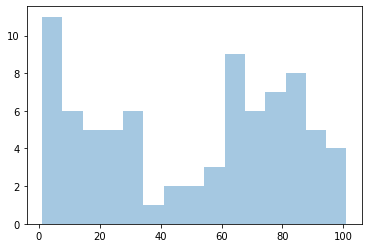

In [39]:
sns.distplot(ranks, bins=15, kde=False)